## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [121]:
import numpy as np
import pandas as pd

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())

<class 'pandas.core.frame.DataFrame'>
                                                   0
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...
3  airport    starts as a brand new luxury    pla...
4  brilliant over  acting by lesley ann warren . ...


In [122]:
# Renaming for convinience
reviews = reviews.rename(columns={0: 'review'})
y = Y

In [123]:
reviews.head()

,review
0,bromwell high is a cartoon comedy . it ran at ...
1,story of a man who has unnatural feelings for ...
2,homelessness or houselessness as george carli...
3,airport starts as a brand new luxury pla...
4,brilliant over acting by lesley ann warren . ...


In [124]:
labels.head()

,0
0,positive
1,negative
2,positive
3,negative
4,positive


In [125]:
# 1 -> positive, 0 -> negative
y.head()

,0
0,1
1,0
2,1
3,0
4,1


**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

In [126]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# We will use stopwords to filter out words without significant semantic meaning.
# It seems like all reviews are in english.
nltk.download('stopwords')
vecotrizer = CountVectorizer(max_features=10_000, stop_words=stopwords.words('english'))
X = vecotrizer.fit_transform(reviews["review"]).toarray()

[nltk_data] Downloading package stopwords to /Users/mibui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [127]:
from sklearn.model_selection import train_test_split

X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_validation, y_train, y_validation= train_test_split(X_, y_, test_size=.25, random_state=42)

In [128]:
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_validation.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (15000, 10000)
Validation set shape: (5000, 10000)
Test set shape: (5000, 10000)


**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

In [129]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [130]:
# Reviews are split 50/50 when it comes to positive and negative reviews.
y.value_counts()

0    12500
1    12500
Name: count, dtype: int64

In [131]:
# baseline accuracy
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.5013333333333333

In [132]:
# Each row in the data set has 10_000 columns. 
# The index of the column maps to a word such that 
# 0 -> word is not present, 1 -> word is present
# [0,0,0] -> word with index 0,1,2 is not present
# [1,0,1] -> word with index 0 (aaron) and 2 (abandoned) is present, while word with index 1 is not present
vecotrizer.get_feature_names_out()

array(['aaron', 'abandon', 'abandoned', ..., 'zoom', 'zorro', 'zu'],
      dtype=object)

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

In [133]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

network = tf.keras.Sequential([
    tf.keras.layers.Dense(units=100, input_dim=X.shape[1], activation='tanh'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

network.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005), metrics = ['accuracy'])

In [134]:
history = network.fit(X_train, y_train, 
                    epochs = 100, 
                    validation_data=(X_validation, y_validation),
                    callbacks = [callback])

Epoch 1/100
469/469 [==============================] - 4s 7ms/step - loss: 0.3352 - accuracy: 0.8556 - val_loss: 0.2841 - val_accuracy: 0.8844
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1504 - accuracy: 0.9423 - val_loss: 0.3450 - val_accuracy: 0.8770
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0765 - accuracy: 0.9717 - val_loss: 0.4446 - val_accuracy: 0.8750
Epoch 4/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0356 - accuracy: 0.9873 - val_loss: 0.5800 - val_accuracy: 0.8720
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0167 - accuracy: 0.9950 - val_loss: 0.6769 - val_accuracy: 0.8720
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.7480 - val_accuracy: 0.8740
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.8191 - val_accuracy: 0.8728

In [135]:
import matplotlib.pyplot as plt

def plot_results(history):
    plt.figure()
    plt.title("Learning curves")
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")
    plt.plot(history.history['loss'], label = 'train')
    plt.plot(history.history['val_loss'], label = 'valid')
    plt.legend()
    plt.show()

    plt.figure()
    plt.title("Learning curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(history.history['accuracy'], label = 'train')
    plt.plot(history.history['val_accuracy'], label = 'valid')
    plt.legend()
    plt.show()

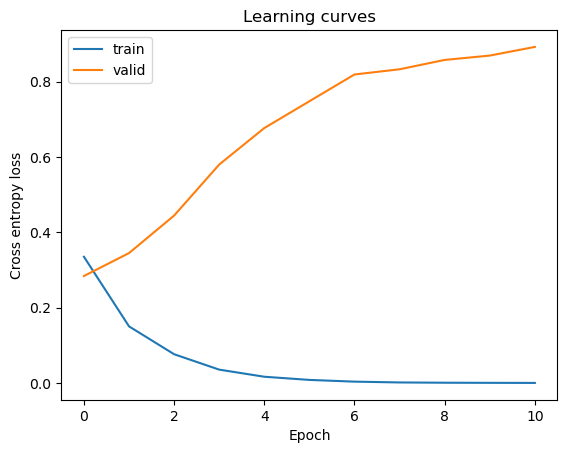

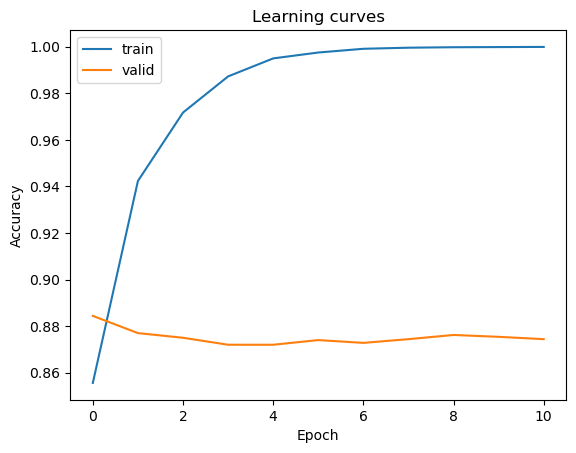

In [136]:
plot_results(history=history)

We notice significant overfitting, so we can try to regulularize, use dropout and experiment with the activation function.

In [137]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

network = tf.keras.Sequential([
    tf.keras.layers.Dense(units=100, input_dim=X.shape[1], activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

network.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005), metrics = ['accuracy'])

In [138]:
history = network.fit(X_train, y_train, 
                    epochs = 100, 
                    validation_data=(X_validation, y_validation),
                    callbacks = [callback])

Epoch 1/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3344 - accuracy: 0.8584 - val_loss: 0.2874 - val_accuracy: 0.8806
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1589 - accuracy: 0.9390 - val_loss: 0.3317 - val_accuracy: 0.8682
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0888 - accuracy: 0.9663 - val_loss: 0.4342 - val_accuracy: 0.8728
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0450 - accuracy: 0.9837 - val_loss: 0.5465 - val_accuracy: 0.8716
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0209 - accuracy: 0.9937 - val_loss: 0.6701 - val_accuracy: 0.8670
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0117 - accuracy: 0.9969 - val_loss: 0.7461 - val_accuracy: 0.8620
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0065 - accuracy: 0.9985 - val_loss: 0.8010 - val_accuracy: 0.8712

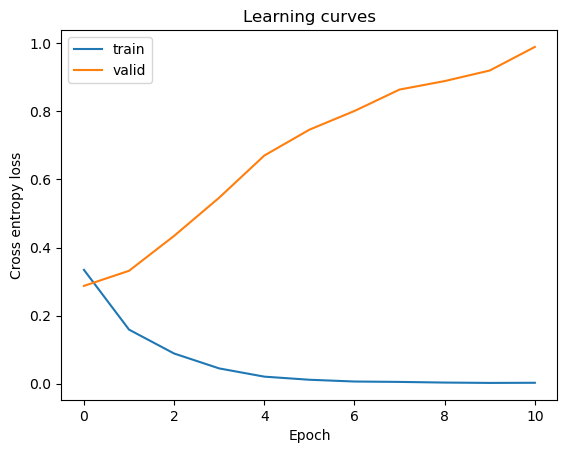

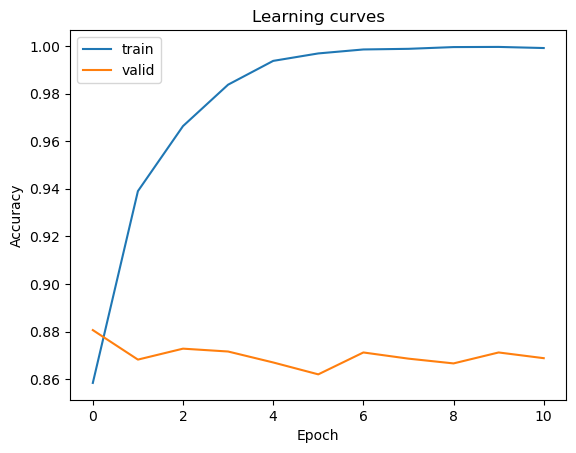

In [139]:
plot_results(history)

In [140]:
from tensorflow.keras import regularizers
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

network = tf.keras.Sequential([
    tf.keras.layers.Dense(units=100, input_dim=X.shape[1], kernel_regularizer=regularizers.l2(0.001),activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

network.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005), metrics = ['accuracy'])

In [141]:
history = network.fit(X_train, y_train, 
                    epochs = 100, 
                    validation_data=(X_validation, y_validation),
                    callbacks = [callback])

Epoch 1/100
469/469 [==============================] - 4s 7ms/step - loss: 0.7415 - accuracy: 0.8377 - val_loss: 0.7462 - val_accuracy: 0.8592
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.7125 - accuracy: 0.8610 - val_loss: 0.7057 - val_accuracy: 0.8598
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6896 - accuracy: 0.8602 - val_loss: 0.7029 - val_accuracy: 0.8544
Epoch 4/100
469/469 [==============================] - 4s 8ms/step - loss: 0.6633 - accuracy: 0.8708 - val_loss: 0.6821 - val_accuracy: 0.8590
Epoch 5/100
469/469 [==============================] - 5s 10ms/step - loss: 0.6438 - accuracy: 0.8727 - val_loss: 0.6983 - val_accuracy: 0.8514
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 0.6264 - accuracy: 0.8747 - val_loss: 0.6771 - val_accuracy: 0.8558
Epoch 7/100
469/469 [==============================] - 4s 8ms/step - loss: 0.6124 - accuracy: 0.8724 - val_loss: 0.6576 - val_accuracy: 0.859

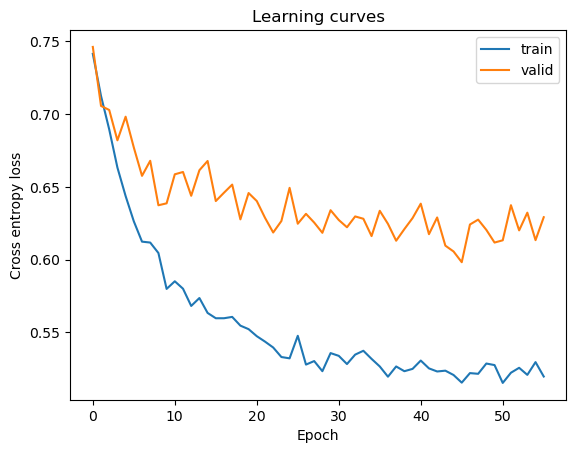

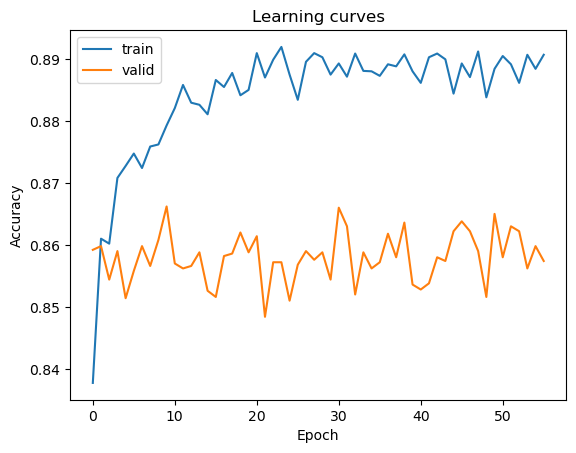

In [142]:
plot_results(history)

Less overfitting, but we don't see any real improvements on the validation set.

**(d)** Test your sentiment-classifier on the test set.

**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [143]:
network.predict(vecotrizer.fit_transform(['This movie sucks']))

ValueError: in user code:

    File "/Users/mibui/anaconda3/envs/ml_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/Users/mibui/anaconda3/envs/ml_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/mibui/anaconda3/envs/ml_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/mibui/anaconda3/envs/ml_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/Users/mibui/anaconda3/envs/ml_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/mibui/anaconda3/envs/ml_env/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 10000), found shape=(None, 2)
